TODO:
Learn to use visualization techniques to study:
1. missing data
2. distributions
3. correlation heatmaps
4. pairplots,
5. t-SNE

pre-proc:
1. use catboost for categoric data

model: 

# tal todo
1. Anamaly detection algo, price, or Best using the pipe class
2. check anomaly+ catboost
3. check pipes + transform all
4. predict with stacking
5. hyper paramentr tuning
# efrat todo
5. one-hot to categoric
6. split to different models for low and high prices
7. check reressions 


# JET House Prices Prediction 

# instruction
## Part 1:
[Model submission is done through Kaggle]
Part 1 - EDA
1. Which 3 features have the highest number of missing values
2. How the price behave over the years?
3. Plot the the feature distribution using histograms
4. Compute and order the features by their correlation with label
5. Add more EDA that will help you understand the data and support your modeling decisions

Part 2 - baseline
1. Train the simplest baseline model possible
2. submit your baseline results and share the results

## Part 2:
[Model submission is done through Kaggle]
Your solution:  go wild and build the best performing model!Which model you choose and why (relate to relevant EDA)?
Choose a validation creation process, why you choose it? what is the baseline performance?
Which smart tricks you used to boost your model performance?
Describe potential generalization issues (e.g. overfit/underfit)? How can you handle these?
submit your model and improve your rank in the leaderboard!

Deliverables
A final submission and score of you team in the leaderboard
Working and easy to follow notebook with the 3 parts completed and that produce your best submission.
Slides explaining your project: 
1. EDA
2. decision made
3. feature analysis
4. validation
5. modeling
6. etc



# Imports and loadings

In [1]:
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import warnings
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import datetime

warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# general functions

In [2]:
def printt(df,Name=None,verbose=True):    
    if verbose==True:
        print('----------------------')
        if Name!=None:
            print(Name)
        if isinstance(df, dict):
            for key, value in df.items():
                print(f"{key}: {value}")
        else:
            print(df)
               


In [3]:
def plot_pred(y, y_pred,verbose=True,addline = True):
    if verbose==True:
        plt.figure(figsize=(5, 5))
        plt.scatter(y, y_pred, color='blue')
        plt.title('True vs Predicted Values')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        if addline: plt.plot([min(y), max(y)], [min(y), max(y)], color='red') # Line for perfect predictions
        plt.grid(True)
        plt.show()


# Load the dataset

In [4]:
test_file_path = "project/test.csv"
train_file_path = "project/train.csv"
testset_df = pd.read_csv(test_file_path)
dataset_df = pd.read_csv(train_file_path)
print("Full test set shape is {}".format(testset_df.shape))
print("Full train dataset shape is {}".format(dataset_df.shape))
id_file = testset_df['Id']

Full test set shape is (1459, 80)
Full train dataset shape is (1460, 81)


## log(y)

In [5]:
dataset_df['SalePrice'] = np.log(dataset_df['SalePrice'])

# Anomaly detection

In [6]:
numeric_features_df = dataset_df.select_dtypes(include='number')
numeric_features_df['LotFrontage'] = dataset_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    numeric_features_df[col] = numeric_features_df[col].fillna(0)
numeric_features_df = numeric_features_df.fillna(numeric_features_df.mean())
scaler = StandardScaler()
standardized_data = pd.DataFrame(scaler.fit_transform(numeric_features_df), columns=numeric_features_df.columns, index=numeric_features_df.index)
isloation_clf = IsolationForest(random_state=0).fit(standardized_data)
isloation_clf.predict(standardized_data)
iso_scores = isloation_clf.score_samples(standardized_data)
iso_scores = pd.DataFrame({'score': iso_scores}, index=standardized_data.index)
combined_df = pd.concat([iso_scores, standardized_data], axis=1).sort_values('score')
combined_df.head(10)

,score,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1298,-0.688442,1.348865,0.073375,10.827594,5.348867,2.821425,-0.517200,1.216598,1.120936,3.835384,...,0.955782,3.704173,-0.359325,-0.116339,-0.270208,11.882444,-0.087688,-1.969111,0.138777,-0.102981
185,-0.629266,-1.291920,0.428102,0.882989,1.246078,2.821425,3.078570,-2.625409,0.394133,-0.574410,...,-0.752176,3.221033,-0.359325,-0.116339,7.085593,-0.068692,-0.087688,-0.119110,-1.367655,2.622038
691,-0.626376,-0.091348,0.073375,1.507314,1.104264,2.821425,0.381743,0.752907,0.491040,5.907323,...,2.296608,0.050424,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.969111,-0.614439,3.782532
523,-0.621624,-0.489957,0.073375,2.666775,2.964284,2.821425,-0.517200,1.183477,1.120936,3.647026,...,0.907895,5.425361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,1.360892,-0.614439,0.257210
635,-0.605999,-0.224218,3.147673,-0.454850,0.038001,-0.071836,1.280685,-1.896752,0.491040,-0.574410,...,-0.752176,0.956312,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,-0.614439,0.455835
197,-0.601796,-1.263448,0.428102,4.628939,1.493526,1.374795,-1.416142,-1.764269,0.248772,-0.574410,...,-0.752176,-0.462913,8.675309,-0.116339,-0.270208,12.679187,-0.087688,-1.229111,-1.367655,0.859697
1182,-0.591963,1.073634,0.073375,4.004614,0.511751,2.821425,-0.517200,0.819149,0.539493,-0.574410,...,0.612594,0.473172,-0.359325,-0.116339,-0.270208,13.749810,-0.087688,0.250891,-0.614439,3.749141
705,-0.578057,-0.058130,3.147673,-0.008904,-0.492774,-1.518467,-0.517200,-1.366820,-1.689368,-0.574410,...,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,6.969431,0.250891,1.645210,-2.777162
1386,-0.572333,1.557660,0.073375,0.437043,0.618888,0.651479,-0.517200,0.222975,-0.332670,0.444939,...,-0.752176,0.986508,-0.359325,-0.116339,7.623823,12.853474,3.944952,0.250891,-1.367655,1.014651
769,-0.567675,0.093721,0.073375,-1.034580,4.308262,1.374795,-0.517200,1.050994,0.878668,2.766175,...,3.262322,-0.160950,-0.359325,-0.116339,3.497397,-0.068692,-0.087688,-0.119110,1.645210,2.933931


In [7]:
from sklearn.svm import OneClassSVM
svm_clf = OneClassSVM(nu=0.01).fit(standardized_data)
svm_scores = svm_clf.score_samples(standardized_data)
svm_scores = pd.DataFrame({'score': svm_scores}, index=standardized_data.index)
combined_df = pd.concat([svm_scores, standardized_data], axis=1).sort_values('score')
combined_df.head(10)

,score,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
649,0.321723,-0.191000,2.911188,-2.194041,-0.859988,-1.518467,0.381743,-0.041991,-0.720298,-0.574410,...,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,-0.614439,-1.701774
185,0.321727,-1.291920,0.428102,0.882989,1.246078,2.821425,3.078570,-2.625409,0.394133,-0.574410,...,-0.752176,3.221033,-0.359325,-0.116339,7.085593,-0.068692,-0.087688,-0.119110,-1.367655,2.622038
706,0.321733,-0.055758,-0.872563,0.437043,10.486449,0.651479,-0.517200,-0.008870,0.830215,1.370110,...,2.280646,0.020227,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.119110,-0.614439,1.487876
58,0.321751,-1.593250,0.073375,-0.187282,0.317220,2.821425,-0.517200,1.150356,1.024029,5.137271,...,0.780197,-0.704483,0.246257,-0.116339,-0.270208,-0.068692,-0.087688,1.360892,-1.367655,2.423406
1170,0.321769,1.045162,0.546344,0.258664,-0.063824,-0.071836,0.381743,0.189854,-0.381123,-0.574410,...,0.867989,-0.704483,-0.359325,-0.116339,-0.270208,14.272672,-0.087688,0.250891,0.138777,0.063529
1283,0.321777,1.313274,0.782828,1.061368,-0.111931,-0.071836,-0.517200,-0.008870,-0.671845,-0.574410,...,0.269406,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210,-0.455334
169,0.321824,-1.329883,-0.872563,0.660016,0.616583,1.374795,0.381743,0.322337,-0.187309,3.043172,...,3.828981,0.261798,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.969111,-1.367655,0.783967
1009,0.321827,0.663162,-0.163109,-0.454850,-0.452686,-0.795151,-0.517200,-1.499303,-1.689368,-0.574410,...,-0.752176,-0.704483,1.899334,-0.116339,-0.270208,-0.068692,-0.087688,-0.119110,-1.367655,-1.230414
137,0.321828,-1.405809,0.782828,0.526232,0.055440,0.651479,-0.517200,0.554183,0.200319,-0.186614,...,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.250891,-1.367655,0.063529
942,0.321832,0.504193,0.782828,-1.257554,-0.281206,-1.518467,-2.315085,0.189854,-0.381123,-0.574410,...,1.809760,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,-0.264604


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
scl = StandardScaler(with_mean=True,with_std=True)
pca.fit(scl.fit_transform(standardized_data))

def reduce_dim_reconstruct(data):
  #Reduce the dimension, reconstruct. Standrtize data.
  return scl.inverse_transform(pca.inverse_transform(pca.transform(scl.transform(data))))

pca_scores = -1* ((standardized_data - reduce_dim_reconstruct(standardized_data)) ** 2).sum(axis=1)
pca_scores = pd.DataFrame({'score': pca_scores}, index=standardized_data.index)
combined_df = pd.concat([pca_scores, standardized_data], axis=1).sort_values('score')
combined_df.head(10)

,score,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
346,-982.720154,-0.909920,-0.872563,0.124880,0.226018,-0.071836,2.179628,-0.373198,0.636400,-0.574410,...,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,31.165268,-0.859110,-0.614439,-0.239685
313,-446.180587,-0.988218,-0.872563,3.558668,20.518273,0.651479,-0.517200,-0.207594,-0.962566,-0.574410,...,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.119110,0.891994,2.030052
1298,-433.461965,1.348865,0.073375,10.827594,5.348867,2.821425,-0.517200,1.216598,1.120936,3.835384,...,0.955782,3.704173,-0.359325,-0.116339,-0.270208,11.882444,-0.087688,-1.969111,0.138777,-0.102981
1423,-367.751167,1.645449,0.546344,-0.209580,0.919354,-0.071836,1.280685,-0.174474,-0.914112,-0.574410,...,3.924754,2.858677,-0.359325,-0.116339,-0.270208,18.306180,-0.087688,0.620891,-1.367655,1.253062
197,-357.442530,-1.263448,0.428102,4.628939,1.493526,1.374795,-1.416142,-1.764269,0.248772,-0.574410,...,-0.752176,-0.462913,8.675309,-0.116339,-0.270208,12.679187,-0.087688,-1.229111,-1.367655,0.859697
205,-312.112111,-1.244467,-0.872563,1.284341,0.133713,0.651479,-0.517200,0.620424,0.248772,-0.574410,...,-0.752176,-0.191147,-0.359325,17.217233,-0.270208,-0.068692,-0.087688,-0.489110,0.891994,0.198929
1230,-310.115715,1.187523,0.782828,0.035691,0.839176,-0.795151,-0.517200,0.189854,-0.381123,-0.568871,...,0.484896,-0.342128,2.013903,-0.116339,-0.270208,-0.068692,16.647766,0.620891,-0.614439,0.327382
335,-278.371506,-0.936019,3.147673,0.660016,15.448542,-0.795151,0.381743,-0.207594,-0.962566,-0.574410,...,4.595168,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,1.323736,0.620891,0.138777,0.794380
810,-275.861218,0.191000,-0.872563,0.347853,-0.037766,-0.071836,0.381743,0.090492,0.684854,-0.025956,...,1.362818,-0.704483,-0.359325,-0.116339,-0.270208,16.065342,-0.087688,-1.969111,-1.367655,0.205856
1386,-260.229392,1.557660,0.073375,0.437043,0.618888,0.651479,-0.517200,0.222975,-0.332670,0.444939,...,-0.752176,0.986508,-0.359325,-0.116339,7.623823,12.853474,3.944952,0.250891,-1.367655,1.014651


In [9]:
ensemble_scores = pd.DataFrame({'score': (svm_scores.score.rank()+iso_scores.score.rank() + pca_scores.score.rank())/3},index=standardized_data.index).sort_values('score')

combined_df = pd.concat([ensemble_scores, standardized_data], axis=1).sort_values('score')
combined_df.head(20)
combined_df['score'].values[:15]
combined_df.head(20)

,score,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
185,5.666667,-1.291920,0.428102,0.882989,1.246078,2.821425,3.078570,-2.625409,0.394133,-0.574410,...,-0.752176,3.221033,-0.359325,-0.116339,7.085593,-0.068692,-0.087688,-0.119110,-1.367655,2.622038
197,7.333333,-1.263448,0.428102,4.628939,1.493526,1.374795,-1.416142,-1.764269,0.248772,-0.574410,...,-0.752176,-0.462913,8.675309,-0.116339,-0.270208,12.679187,-0.087688,-1.229111,-1.367655,0.859697
1298,15.000000,1.348865,0.073375,10.827594,5.348867,2.821425,-0.517200,1.216598,1.120936,3.835384,...,0.955782,3.704173,-0.359325,-0.116339,-0.270208,11.882444,-0.087688,-1.969111,0.138777,-0.102981
1173,26.333333,1.052280,-0.163109,3.023532,0.752985,-0.795151,0.381743,-0.836889,0.442586,-0.574410,...,0.221520,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,-0.614439,0.462088
523,31.000000,-0.489957,0.073375,2.666775,2.964284,2.821425,-0.517200,1.183477,1.120936,3.647026,...,0.907895,5.425361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,1.360892,-0.614439,0.257210
942,31.666667,0.504193,0.782828,-1.257554,-0.281206,-1.518467,-2.315085,0.189854,-0.381123,-0.574410,...,1.809760,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,-0.264604
1423,33.333333,1.645449,0.546344,-0.209580,0.919354,-0.071836,1.280685,-0.174474,-0.914112,-0.574410,...,3.924754,2.858677,-0.359325,-0.116339,-0.270208,18.306180,-0.087688,0.620891,-1.367655,1.253062
496,34.000000,-0.554019,-0.872563,0.927584,0.218000,1.374795,-0.517200,0.686666,0.394133,-0.574410,...,1.354837,0.427877,4.403498,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,2.372787
635,36.333333,-0.224218,3.147673,-0.454850,0.038001,-0.071836,1.280685,-1.896752,0.491040,-0.574410,...,-0.752176,0.956312,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,-0.614439,0.455835
249,36.333333,-1.140069,-0.163109,0.437043,14.881285,-0.071836,1.280685,-0.439440,1.024029,2.040443,...,-0.752176,0.775134,-0.359325,-0.116339,-0.270208,-0.068692,0.920472,-0.119110,-0.614439,1.271482


In [10]:
PerformAnomalyDrop = False
if PerformAnomalyDrop == True:
    indices_to_show = [523, 1298, 30, 88, 462, 632, 1324]
    entries_to_show = dataset_df.loc[indices_to_show]
    indices_to_throw = [1298, 1182, 1386, 691, 185, 496 ]
    #indices_to_throw = combined_df.index.values[:6]
    #dataset_df = dataset_df[dataset_df.GrLivArea < 4500]
    dataset_df =  dataset_df.drop(indices_to_throw)
    dataset_df.reset_index(drop=True, inplace=True)
    y = dataset_df['SalePrice'].reset_index(drop=True)
    id_file = testset_df['Id']
    entries_to_show[['MiscVal', 'SalePrice']]
    #entries_to_show

In [11]:
# custom_quantiles = combined_df['score'].quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9])
# custom_quantiles

In [12]:
# Assuming 'dataset_df' is your DataFrame
y = dataset_df['SalePrice']
X = dataset_df.drop('SalePrice', axis=1)
# Splitting the dataset into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
if 0:
    # Assuming numerical_features is a list of column names of numerical features
    numerical_features = dataset_df.select_dtypes(include=['int64', 'float64']).columns
    
    # Create box plots for all numerical features
    # for feature in numerical_features:
    #     plt.figure(figsize=(8, 6))
    #     sns.boxplot(x=dataset_df[feature])
    #     plt.title(f'Box plot of {feature}')
    #     plt.show()
    # Create box plots and scatter plots for each numerical feature
    for feature in numerical_features:
        # Create a new figure with two subplots in one row
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
        # Box plot
        sns.boxplot(x=dataset_df[feature], ax=axes[0])
        axes[0].set_title(f'Box plot of {feature}')
    
        # Scatter plot
        sns.scatterplot(x=dataset_df[feature], y=dataset_df['SalePrice'], ax=axes[1])
        axes[1].set_title(f'Scatter plot of {feature} vs SalePrice')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('SalePrice')
    
        # Adjust layout
        plt.tight_layout()
    
        # Show the plots
        plt.show()

The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

# EDA

## explain_feature

In [14]:
def explain_feature(feature_name, file_path="project/data_description.txt"):
    feature_name_lower = feature_name.lower()
    with open(file_path, "r") as file:
        lines = file.readlines()
        collecting = False
        for line in lines:
            if feature_name_lower in line.lower():
                collecting = True
            elif collecting and ":" in line and not line.lower().startswith(feature_name_lower):
                # If we're collecting and encounter a line with a colon that doesn't start with the feature name,
                # it's likely the start of another feature's description.
                break
            
            if collecting:
                print(line.strip())

# Example usage
explain_feature("MSSubClass")

MSSubClass: Identifies the type of dwelling involved in the sale.

20	1-STORY 1946 & NEWER ALL STYLES
30	1-STORY 1945 & OLDER
40	1-STORY W/FINISHED ATTIC ALL AGES
45	1-1/2 STORY - UNFINISHED ALL AGES
50	1-1/2 STORY FINISHED ALL AGES
60	2-STORY 1946 & NEWER
70	2-STORY 1945 & OLDER
75	2-1/2 STORY ALL AGES
80	SPLIT OR MULTI-LEVEL
85	SPLIT FOYER
90	DUPLEX - ALL STYLES AND AGES
120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150	1-1/2 STORY PUD - ALL AGES
160	2-STORY PUD - 1946 & NEWER
180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190	2 FAMILY CONVERSION - ALL STYLES AND AGES



## categoric

In [15]:
def set_order_categoric_to_numeric(X,y=None,verbose=False):
# Assuming X is your DataFrame
 if 0:
    category_sets = [
        set(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NotExist']),
        set(['Gd', 'Av', 'Mn', 'No', 'NotExist']),
        set(['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NotExist']),
        set(['Fin','RFn','Unf','NotExist']),
        set(['GdPrv','MnPrv','GdWo','MnWw','NotExist']),
    ]
    titles = ['quality_mapping', 'access_mapping', 'basement_mapping', 'garage_mapping', 'fence_mapping']
    
    # Mappings
    quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NotExist': 0}
    access_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NotExist': 0}
    basement_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NotExist': 0}
    garage_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
    fence_mapping = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NotExist': 0}
    
    # Mapping from titles to actual mappings
    mapping_dict = {
        'quality_mapping': quality_mapping,
        'access_mapping': access_mapping,
        'basement_mapping': basement_mapping,
        'garage_mapping': garage_mapping,
        'fence_mapping': fence_mapping,
    }
    
    # Select columns of object type
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    
    matching_categories = {}
    for col in col_object:
        vals = set(X[col].unique())
        # Check which category set vals belongs to
        for index, category_set in enumerate(category_sets):
            if vals.issubset(category_set):  # Check if all elements of vals are in the category_set
                matching_categories[col] = titles[index]                
                break  # Exit the loop if a matching set is found

    # Apply the matched mappings to the columns
    X_ = X.copy()
    for col, title in matching_categories.items():
        if title in mapping_dict:
            X_[col] = X[col].map(mapping_dict[title])

    if verbose==True:
        printt(len(matching_categories),'matching_categories')
        print(list(matching_categories.keys()))
        for col, title in matching_categories.items():
            if y is not None and not y.empty:
                categoric_analysis(X[[col]],y,True)
            print(f"{col}: {title} : {mapping_dict[title]}")
    
    return X_


----------------------
number of categorical
1
----------------------
categorical List
['BldgType']
----------------------
BldgType

1
BldgType: Type of dwelling

1Fam	Single-family Detached
2FmCon	Two-family Conversion; originally built as one-family dwelling
Duplx	Duplex
TwnhsE	Townhouse End Unit
TwnhsI	Townhouse Inside Unit

        col     val ymean ystd  number ratio
0  BldgType  2fmCon 11.73 0.28      31  2.12
1  BldgType   Twnhs 11.77 0.31      43  2.95
2  BldgType  Duplex 11.78 0.21      52  3.56
3  BldgType    1Fam 12.05 0.41    1220 83.56
4  BldgType  TwnhsE 12.06 0.32     114  7.81


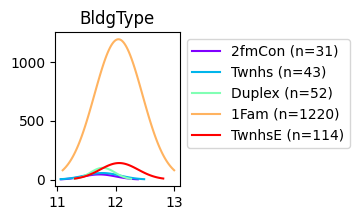

In [16]:
def categoric_analysis(X,y,verbose=False):
    #col_object = X.select_dtypes(include=['O']).columns.tolist()
    cols = X.columns.tolist()
    #cols = X.columns.tolist()
    printt(len(cols),'number of categorical',verbose=verbose)
    printt(cols,'categorical List',verbose=verbose)
    i=0
    for col in cols:
        i = i+1
        vals = X[col].unique()        
        cols = [col for _ in range(len(vals))]  # This will create a list with 'title' repeated
        #print('\n'.join(str(val) for val in vals))
        ymean  = [np.mean(y[X[col] == val])  for val in vals]
        ystd   = [np.std(y[X[col] == val])   for val in vals]
        ratios = [np.mean(X[col] == val)*100         for val in vals]
        numbers = [np.sum(X[col] == val)             for val in vals]

        df = pd.DataFrame({'col': cols, 'val': vals, 'ymean': ymean, 'ystd': ystd,'number': numbers, 'ratio': ratios})
        df.loc[pd.isna(vals), 'ratio'] = np.mean(X[col].isna())*100
        df.loc[pd.isna(vals), 'number'] = np.sum(X[col].isna())
        df.loc[pd.isna(vals), 'ymean'] = np.mean(y[X[col].isna()])
        df.loc[pd.isna(vals), 'ystd'] = np.std(y[X[col].isna()])
        df = df.sort_values(by='ymean', ascending=True).reset_index(drop=True)  # Use ascending=False for descending order
        # This will apply the formatting and then convert the DataFrame to a string for printing
        formatted_df_string = df.to_string(formatters={'ymean': "{:.2f}".format, 'ystd': "{:.2f}".format, 'ratio': "{:.2f}".format})
        printt('',col,verbose=verbose)      
        if verbose==True:        
            print(i)
            explain_feature(col)
            print(formatted_df_string)        
            plot_categoric(df,col)
    return df

def plot_categoric(df,col):
        ymean = df['ymean'].values
        ystd = df['ystd'].values
        numbers = df['number'].values
        vals = df['val'].values        
            # Plotting
        plt.figure(figsize=(2, 2))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(vals)))  # Generate distinct colors

        for i, mean in enumerate(ymean):
            # Generate x values
            x = np.linspace(norm.ppf(0.01, loc=mean, scale=ystd[i]),
                            norm.ppf(0.99, loc=mean, scale=ystd[i]), 100)
            # Generate y values for Gaussian curve
            y_gauss = norm.pdf(x, loc=mean, scale=ystd[i]) * numbers[i]  # Scale by 'num'
            plt.plot(x, y_gauss, label=f'{vals[i]} (n={numbers[i]})', color=colors[i])

        plt.title(f'{col}')
        plt.legend()
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.subplots_adjust(right=0.75)
        plt.show()


#categoric_analysis(X[['ExterQual']],y,True)
#categoric_analysis(X[['Condition1']],y,True)
 
manual_feature_importance = {
    'not': ['Street','LandContour','Utilities','LotConfig','LandSlope','Condition2','RoofMatl','ExterCond','Heating','Functional','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature'],
    'low': ['Alley','Condition1','BsmtCond','BsmtFinType2','CentralAir','Electrical'],
    'med': ['MSZoning','BldgType','HouseStyle','RoofStyle','Exterior1st','Exterior2nd','BsmtExposure','BsmtFinType1','SaleType','SaleCondition'],
    'high': ['LotShape','Neighborhood','MasVnrType','ExterQual','Foundation','BsmtQual','HeatingQC','KitchenQual','FireplaceQu','GarageType','GarageFinish']
}
#example of use
if 0:
    categoric_analysis(X[manual_feature_importance['high']],y,True)
if 1:
    df = categoric_analysis(X[['BldgType']],y,True)
if 0:
    df = categoric_analysis(X[['MoSold','MSSubClass']],y,True)

In [17]:
def categoric_to_numeric_maping(df,MinRatioPerGroup = 10 ,verbose=False):
    #df = pd.DataFrame({'col': cols, 'val': vals, 'ymean': ymean, 'ystd': ystd,'number': numbers, 'ratio': ratios})
    MinRatioPerGroup = 100/np.floor(100/MinRatioPerGroup)
    # diveide to groups
    sum_ratio = 0
    group = 0
    for i in range(len(df)):
        sum_ratio = sum_ratio + df.loc[i,'ratio']        
        df.loc[i,'group'] = group
        if sum_ratio>=MinRatioPerGroup:
           sum_ratio = 0
           group = group + 1        
    # add last group to prev if it's too small
    last_group_indexes = (df['group'] == group)
    if np.sum(df.loc[last_group_indexes,'ratio'])<MinRatioPerGroup:
        df.loc[last_group_indexes,'group'] = group-1

    # add last group to prev if it's too small
    if np.sum(df.loc[last_group_indexes,'ratio'])<MinRatioPerGroup:        
        df.loc[last_group_indexes,'group'] = group-1

    NGroups = int(df['group'].max()) + 1
    # calc mean y per group
    for g in range(NGroups):
        group_indexes = (df['group'] == g)
        ymean_group = np.sum(df.loc[group_indexes,'ymean']*df.loc[group_indexes,'number'])/np.sum(df.loc[group_indexes,'number'])
        df.loc[group_indexes,'ymean_group'] = ymean_group
        df.loc[group_indexes,'number_group'] = np.sum(df.loc[group_indexes,'number'])
        df.loc[group_indexes,'ratio_group'] = np.sum(df.loc[group_indexes,'ratio'])
    #print(df)
    val_to_ymean_map = df.set_index('val')['ymean_group'].to_dict()
    val_to_group_map = df.set_index('val')['group'].to_dict()
    return val_to_ymean_map,val_to_group_map


def categoric_to_numeric_fit(X,y,categortic_config_params,cols=None, JustCategoric=True,verbose=False):
    MinRatioPerGroup = categortic_config_params['MinRatioPerGroup']
    if JustCategoric==True:
        exist_cols = X.select_dtypes(include=['O']).columns.tolist()
    else:
        exist_cols = X.columns.tolist()

    if cols is None:
        cols = exist_cols
    else:
        filtered_cols = [col for col in cols if col in exist_cols]
        cols = filtered_cols
    categoric_map = dict()
    for col in cols:
        df = categoric_analysis(X[[col]],y,False)
        val_to_ymean_map,val_togroup_map = categoric_to_numeric_maping(df,MinRatioPerGroup,verbose=verbose)   
        if categortic_config_params['replaceby']=='ymean':
            categoric_map[col] = val_to_ymean_map
        else:
            categoric_map[col] = val_togroup_map  
        printt(df,'df in categoric_to_numeric_fit',verbose=verbose)
        printt(categoric_map,'categoric_map in categoric_to_numeric_fit',verbose=verbose)
    return categoric_map
def categoric_to_numeric_transform(X,categoric_map,verbose=False):
    X_ = X.copy()
    for col in categoric_map:
        X_[col] = X_[col].map(categoric_map[col])        
    return X_

#ExampleOfuse
if 1:
    categortic_config_params1 = dict()
    categortic_config_params1['MinRatioPerGroup'] = 15
    categortic_config_params1['replaceby'] = 'ymean' #'ymean', 'group_nember'
    cols = manual_feature_importance['high']
    categoric_map = categoric_to_numeric_fit(X,y,categortic_config_params1,cols=cols,JustCategoric=True,verbose=False)
    X_numeric = categoric_to_numeric_transform(X,categoric_map,verbose=False)
    
    col_to_map_num = ['MSSubClass']
    categoric_map_num = categoric_to_numeric_fit(X_numeric,y,categortic_config_params1,cols=col_to_map_num,JustCategoric=False,verbose=False)
    print(categoric_map_num)
    X_numeric = categoric_to_numeric_transform(X_numeric,categoric_map_num,verbose=False)
    
    col_object1 = X.select_dtypes(include=['O']).columns.tolist()
    col_object2 = X_numeric.select_dtypes(include=['O']).columns.tolist()
    print(len(col_object1),len(col_object2))
    printt(X_numeric['MSSubClass'])


{'MSSubClass': {30: 11.717627406309452, 180: 11.717627406309452, 45: 11.717627406309452, 190: 11.717627406309452, 90: 11.717627406309452, 160: 11.717627406309452, 50: 11.717627406309452, 40: 12.036580782785146, 85: 12.036580782785146, 70: 12.036580782785146, 80: 12.036580782785146, 20: 12.036580782785146, 75: 12.292572463914874, 120: 12.292572463914874, 60: 12.292572463914874}}
43 32
----------------------
0       12.292572
1       12.036581
2       12.292572
3       12.036581
4       12.292572
          ...    
1455    12.292572
1456    12.036581
1457    12.036581
1458    12.036581
1459    12.036581
Name: MSSubClass, Length: 1460, dtype: float64


# Pre proccessing functions

## drop ID

In [18]:
# Custom transformer to remove NAs
class drop_ID(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In drop_ID fit',verbose=self.verbose)
        return self

    def transform(self, X, y=None):
        printt(X.shape,'drop_ID in X.shape',verbose=self.verbose)
        # Ensure 'Id' column is removed safely
        if 'Id' in X.columns:
            return X.drop('Id', axis=1)
        else:
            return X

## NAs

In [19]:
def imput_mean(X,mean):
    for col in X.columns:        
        X[col].fillna(mean, inplace=True)
    return X

In [20]:
def imput_mean_mode(X,mean_mode):
    # impute missing value by pre calc mean or mode :
    for col in X.columns:        
        X[col].fillna(mean_mode[col], inplace=True)
    return X

In [21]:
def imput_mean_per_Neighborhood(X,mean_per_Neighborhood,mean_mode,feature='Neighborhood'):
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    for col in col_numeric:
        row_index = pd.isna(X[col])
        # Iterate over each row that contains NaN in the current column
        for idx in X[row_index].index:
            # Get the Neighborhood value for the current row
            NeighborhoodVal = X.loc[idx, feature]            
            # If the combination exists in the mean_per_Neighborhood, fill NaN with the mean value
            if (NeighborhoodVal, col) in mean_per_Neighborhood:
                X.loc[idx, col] = mean_per_Neighborhood[NeighborhoodVal, col]
            else:
                X.loc[idx, col] = mean_mode[col]
    return X

def calc_mean_Pef_feature(X,feature='Neighborhood'):
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    mean_per_Neighborhood = X.groupby(feature)[col_numeric].mean()
    return mean_per_Neighborhood

if 0:
    mean_per_Neighborhood = calc_mean_Pef_feature(X,feature='Neighborhood')
    X_New_ = imput_mean_per_Neighborhood(X,mean_per_Neighborhood,feature='Neighborhood')
    printt(mean_per_Neighborhood,'combined_stats_perNeighborhood')

In [22]:
    
def calc_mean_mode(X):
    # find the mean of numrical columns and the mode of object columns
    # return :
    # combined_stats = mean amd mode in the same shape as orign,
    # col_numeric,col_object =list of numeric and obkect coumln names
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    printt(col_numeric,'col_numeric',False)
    printt(col_object,'col_object',False)
    # save the mean and the mode for later imputation
    means = X[col_numeric].mean()
    modes = X[col_object].mode().iloc[0]
    # Step 3: Combine results, maintaining the original arrangement
    combined_stats = pd.Series(dtype=object)
    for col in X.columns:
        if col in means:
            combined_stats[col] = means[col]
        elif col in modes:
            combined_stats[col] = modes[col]
    return combined_stats,col_numeric,col_object
    
if 0:
    combined_stats = calc_mean_mode(X)


In [23]:
def find_bad_col(X,threshold=None,verbose=False):
    # drop col with na in amount more than threshold
    if threshold is not None:
        thresh = len(X)*threshold//1        
        na_counts    = X.isna().sum()
        columns_to_keep_ = na_counts[na_counts < thresh].index
        columns_to_remove_ = na_counts[na_counts >= thresh].index
    else:
        columns_to_keep_ = X.columns
        columns_to_remove_ = pd.Index([])        

    if verbose==True:
        nan_counts  = X.isna().sum().sort_values(ascending=False).head(20)/len(X)*100
        print(f"features with the highest number of missing values in %")
        print(f"{nan_counts}%")
        printt(len(columns_to_keep_),'len(columns_to_keep_)',verbose=verbose)
        printt(len(columns_to_remove_),'len(columns_to_remove_)',verbose=verbose)
        if len(columns_to_remove_)>0:
            printt(columns_to_remove_,'columns_to_remove_',verbose=verbose)           

    return columns_to_keep_,columns_to_remove_


In [24]:
def print_row_nan_counts(X,verbose=False):
    # print number of Rows with missing values
    row_nan_counts = X.isna().sum(axis=1) 
    top_row_nan_counts = row_nan_counts.sort_values(ascending=False)
    if verbose==True:
        print("number of Rows with missing values:")
        print(top_row_nan_counts.value_counts())


In [25]:
def print_missingVal_groups(X,verbose=False):
    row_nan_counts = X.isna().sum(axis=1) 
    rows_with_missing_values = X[row_nan_counts >0]
    unique_missing_column_groups = set()
    # Iterate through rows and identify unique groups of missing columns
    for _, row in rows_with_missing_values.iterrows():
        # Extract groups of 5 columns
        groups = tuple(row.index[row.isna()])
        # Add the unique group to the set
        unique_missing_column_groups.add(groups)
    
    # Sort the unique groups by their length
    sorted_unique_missing_column_groups = sorted(unique_missing_column_groups, key=lambda x: len(x))
    # Print the unique groups of 5 missing columns
    if verbose==True:
        print('\nmissing values groups:')
        for i, group in enumerate(sorted_unique_missing_column_groups, start=1):
            print(f"Group {i} of {len(group)} missing columns: {group}")

In [26]:
class remove_NAs_col(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=None,verbose=False):        
        self.threshold = threshold  # Minimum non-NA values required to keep a column
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In RemoveNAs Col fit',verbose=self.verbose)
        # If threshold is set, identify columns to keep based on the threshold
        self.columns_to_keep_,self.columns_to_remove_ = find_bad_col(X,self.threshold,self.verbose)
        return self
    
    def transform(self, X, y=None):
        printt('','In RemoveNAs Col transform',verbose=self.verbose)
        # Drop columns not meeting the threshold requirement
        printt(X.shape,'X.shape',verbose=self.verbose)
        X_transformed = X.loc[:, self.columns_to_keep_]
        printt(X_transformed.shape,'X_transformed.shape',verbose=self.verbose)        
        return X_transformed

In [27]:
class imput_NAs_row(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.column_means_ = None
        self.verbose = verbose
        self.col_numeric = None
        self.col_object = None
        self.mean_per_Neighborhood = None
    def fit(self, X, y=None):
        printt('','In imput_NAs_row fit',verbose=self.verbose)
        # Calculate mean values for each column, ignoring NA's
        printt(X.shape,'imput_NAs_row in X.shape',verbose=self.verbose)
        # save the mean and the mode for later imputation
        self.mean_mode,self.col_numeric,self.col_object = calc_mean_mode(X)
        self.mean_per_Neighborhood = calc_mean_Pef_feature(X,feature='Neighborhood')
        print_row_nan_counts(X,verbose=self.verbose)
        print_missingVal_groups(X,verbose=self.verbose)        
        return self
    
    def transform(self, X, y=None):
        printt('','In imput_NAs_row transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','filing Garage and Bsmt',verbose=self.verbose)
        # Replace NaN values in the specified columns for rows where 'TotalBsmtSF' is equal to 0 with 'NotExist'
        basement_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
        Garage_list = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        X.loc[X['TotalBsmtSF'] == 0, basement_list] = X.loc[X['TotalBsmtSF'] == 0, basement_list].fillna('NotExist')
        X.loc[X['GarageArea'] == 0, Garage_list] = X.loc[X['GarageArea'] == 0, Garage_list].fillna('NotExist')
        print_row_nan_counts(X,verbose=self.verbose)
        # special imputation
        printt('','special imputation',verbose=self.verbose)
        X['GarageYrBlt'].fillna(X['YearBuilt'], inplace=True)        
        X['BsmtFinType2'].fillna('NotExist', inplace=True)
        X['BsmtExposure'].fillna('NotExist', inplace=True)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','imput_mean_mode',verbose=self.verbose)
        imput_mean_per_Neighborhood = False
        if imput_mean_per_Neighborhood==True:
            X = imput_mean_per_Neighborhood(X,self.mean_per_Neighborhood,self.mean_mode,feature='Neighborhood')
        X = imput_mean_mode(X,self.mean_mode)
        print_row_nan_counts(X,verbose=self.verbose)
        return X

## handle categorical

In [28]:
def replace_qual_categoric(X,y=None,verbose=False):
# Assuming X is your DataFrame

    category_sets = [
        set(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NotExist']),
        set(['Gd', 'Av', 'Mn', 'No', 'NotExist']),
        set(['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NotExist']),
        set(['Fin','RFn','Unf','NotExist']),
        set(['GdPrv','MnPrv','GdWo','MnWw','NotExist']),
    ]
    titles = ['quality_mapping', 'access_mapping', 'basement_mapping', 'garage_mapping', 'fence_mapping']
    
    # Mappings
    quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NotExist': 0}
    access_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NotExist': 0}
    basement_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NotExist': 0}
    garage_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
    fence_mapping = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NotExist': 0}
    
    # Mapping from titles to actual mappings
    mapping_dict = {
        'quality_mapping': quality_mapping,
        'access_mapping': access_mapping,
        'basement_mapping': basement_mapping,
        'garage_mapping': garage_mapping,
        'fence_mapping': fence_mapping,
    }
    
    # Select columns of object type
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    
    matching_categories = {}
    for col in col_object:
        vals = set(X[col].unique())
        # Check which category set vals belongs to
        for index, category_set in enumerate(category_sets):
            if vals.issubset(category_set):  # Check if all elements of vals are in the category_set
                matching_categories[col] = titles[index]                
                break  # Exit the loop if a matching set is found

    # Apply the matched mappings to the columns
    X_ = X.copy()
    for col, title in matching_categories.items():
        if title in mapping_dict:
            X_[col] = X[col].map(mapping_dict[title])

    if verbose==True:
        printt(len(matching_categories),'matching_categories')
        print(list(matching_categories.keys()))
        for col, title in matching_categories.items():
            if y is not None and not y.empty:
                categoric_analysis(X[[col]],y,True)
            print(f"{col}: {title} : {mapping_dict[title]}")
    
    return X_

#replace_qual_categoric()
def print_features(X,y,col_list=None): 
    if col_list is None:
        col_list = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond']
    columns_to_keep_,columns_to_remove_ = find_bad_col(X,.15)
    Xnew = X.loc[:, columns_to_keep_]
    print(Xnew.shape)
    imp = imput_NAs_row()
    imp.fit(Xnew)
    Xnew = imp.transform(Xnew)
    print(Xnew.shape)
    X_ = replace_qual_categoric(Xnew[col_list],y,verbose=True)
    Xnew.shape,X_.shape

if 0:
    print_features(X,y)

In [29]:
class handle_categoric(BaseEstimator, TransformerMixin):
    def __init__(self,categortic_config_params,verbose=False,col_to_map=None):        
        self.col_numeric = None
        self.verbose = verbose
        self.col_object = None
        self.col_to_map = col_to_map
        self.col_to_map_num = ['MoSold','MSSubClass']
        self.categoric_map_num = None
        self.categortic_config_params = categortic_config_params
        self.ymean = None
    def fit(self, X, y=None):
        printt('','In categoric fit',verbose=self.verbose)
        self.col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.col_object = X.select_dtypes(include=['O']).columns.tolist()
        #col_to_map = manual_feature_importance['high']
        col_to_map = self.col_object
        self.categoric_map  = categoric_to_numeric_fit(X,y,self.categortic_config_params,cols=col_to_map,JustCategoric=True,verbose=self.verbose)
        self.categoric_map_num = categoric_to_numeric_fit(X,y,self.categortic_config_params,cols=self.col_to_map_num,JustCategoric=False,verbose=self.verbose)
        self.ymean = np.mean(y)
        return self
    
    def transform(self, X):
        printt(f"drop_categoric: {self.categortic_config_params['drop_categoric']}",'',verbose=self.verbose)
        # for now remove all categoric TODO: improve this
        printt('','In categoric transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)

        if self.categortic_config_params['drop_categoric']=='KeepJustOrdered' :
            X = replace_qual_categoric(X,verbose=self.verbose)
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            left_objects = len(X.select_dtypes(include=['O']).columns.tolist())
            printt('',f'number of num feature befor {len(self.col_numeric)}, added {len(col_numeric) - len(self.col_numeric)}, left_objects: {left_objects}',verbose=self.verbose)
            X = X.loc[:, col_numeric]

        if self.categortic_config_params['drop_categoric'] == 'TransformAll':       
            printt('','I am in Transform Categoric',verbose=self.verbose)
            X = categoric_to_numeric_transform(X,self.categoric_map,verbose=self.verbose)
            X = categoric_to_numeric_transform(X,self.categoric_map_num,verbose=self.verbose)
            X = imput_mean(X,self.ymean)
            #display(X)
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            X = X.loc[:, col_numeric]            
            
        if self.categortic_config_params['drop_categoric'] =='DropAll':
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            X = X.loc[:, col_numeric]

        #printt(X.shape,'X.shape')
        #printt(len(X.select_dtypes(include=['O']).columns.tolist()),'length Object')
        #printt(X.select_dtypes(include=['O']).columns.tolist())
        return X

## Anomaly Detection

In [30]:
class AnomalyDetection(BaseEstimator, TransformerMixin):
    def __init__(self,verbose=False):        
        self.verbose = verbose
    def fit(self, X, y=None):
        return self    
    def transform(self, X):
        return self

# Config params

In [31]:
categortic_config_params = dict()
categortic_config_params['MinRatioPerGroup'] = 10
categortic_config_params['replaceby'] = 'ymean' #'ymean', 'group_nember'
#categortic_config_params['categoric_to_replace'] ='just_high' # 'All','from_low_to_high','from_med_to_high','just_high'
categortic_config_params['drop_categoric'] = 'TransformAll' #'KeepAll','KeepJustOrdered','TransformAll','DropAll', KeepAll is the best option

Config_params = dict()
Config_params['nan_counts_threshold'] = .15
Config_params['filter_out_HighNA'] = 1
Config_params["model"]='CatBoost' #'DecisionTree','CatBoost', CatBoost is the best option
Config_params["take_log_target"] = 0 # 0,1  . 1 is the best option
Config_params["verbose"]=False # False,True
Config_params["categortic_config_params"] = categortic_config_params



# pipeline

In [32]:
# Function to create and return a pipeline based on the configuration
def create_pipeline(config_params):
    verbose = Config_params["verbose"]
    categortic_config_params = config_params["categortic_config_params"]
    printt(Config_params['model'],verbose = verbose)
    # Dynamically select the model based on config_params
    printt(Config_params['model'],'Model',verbose=verbose)
    if config_params['model'] == 'LinearRegression':
        model = LinearRegression()
    if config_params['model'] == 'DecisionTree':
        model = DecisionTreeRegressor(random_state=42)
    elif config_params['model'] == 'CatBoost':
        #
        if categortic_config_params['drop_categoric'] == 'KeepAll':
            #categorical_columns = X.select_dtypes(include=['O']).columns.tolist()
            categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour',
                               'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                               'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
                               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                               'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
                               'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
                               'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
            model = CatBoostRegressor(random_seed=42, silent=True, cat_features = categorical_columns)
        else:
            model = CatBoostRegressor(random_state=42, verbose=int(verbose))  # Adjust verbosity for CatBoost
        #printt(len(categorical_columns),'length categorical_columns')
        #print(categorical_columns)
    if (config_params['model'] == 'CatBoost') & (categortic_config_params['drop_categoric'] == 'KeepAll'):
        pipeline = Pipeline([
            ('drop_ID', drop_ID(verbose=verbose)),
            ('remove_nas_col', remove_NAs_col(threshold=config_params['nan_counts_threshold'], verbose=verbose)),
            ('imput_nas_row', imput_NAs_row(verbose=verbose)),
            ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose)),
            ('reg', model)  # Use the dynamically selected model
        ])
    else:
        pipeline = Pipeline([
            ('drop_ID', drop_ID(verbose=verbose)),
            ('remove_nas_col', remove_NAs_col(threshold=config_params['nan_counts_threshold'], verbose=verbose)),
            ('imput_nas_row', imput_NAs_row(verbose=verbose)),
            ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose)),
            ('robust_scaler', RobustScaler()),
            ('reg', model)  # Use the dynamically selected model
        ])

    
    return pipeline


In [33]:
model_lr = LinearRegression()
model_dt = DecisionTreeRegressor(random_state=42)
model_cat = CatBoostRegressor(random_state=42, verbose=0)  # Adjust verbosity for CatBoost


pipeline = create_pipeline(Config_params)
XX = pipeline.named_steps['drop_ID'].fit_transform(X_train)
XX = pipeline.named_steps['remove_nas_col'].fit_transform(XX)
XX = pipeline.named_steps['imput_nas_row'].fit_transform(XX)
XX = pipeline.named_steps['handle_categoric'].fit_transform(XX,y=y_train)
XX = pipeline.named_steps['robust_scaler'].fit_transform(XX)
model_lr.fit(XX,y=y_train)
model_dt.fit(XX,y=y_train)
model_cat.fit(XX,y=y_train)
#pipeline.named_steps['reg'].fit(XX,y=y_train)


XX = pipeline.named_steps['drop_ID'].transform(X_validation)
XX = pipeline.named_steps['remove_nas_col'].transform(XX)
XX = pipeline.named_steps['imput_nas_row'].transform(XX)
XX = pipeline.named_steps['handle_categoric'].transform(XX)
XX = pipeline.named_steps['robust_scaler'].transform(XX)
#y_pred = pipeline.named_steps['reg'].predict(XX)
y_lr = model_lr.predict(XX)
y_dt = model_dt.predict(XX)
y_cat = model_cat.predict(XX)

    
#XX.info()

logRMS y_dt = 0.19770
logRMS y_lr = 0.13905
logRMS y_cat = 0.13288
logRMS y_comb = 0.12658
logRMS y_cat_keepAll = 0.13107


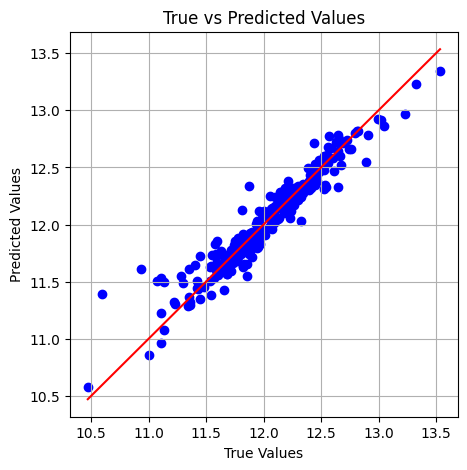

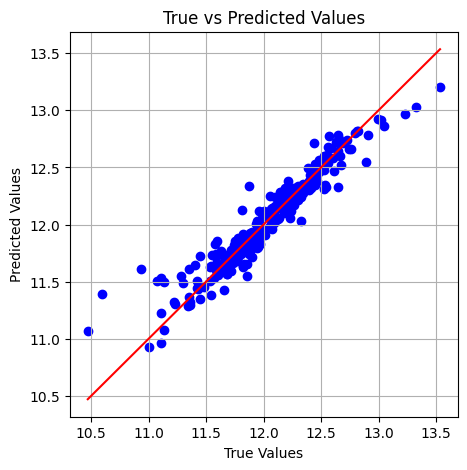

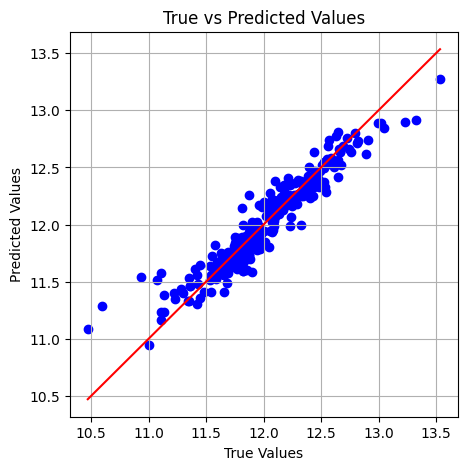

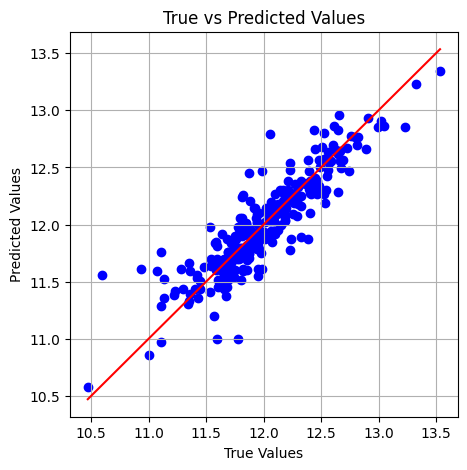

In [34]:
create_pipeline
def CatKeepAllModel(X,y,x_test):
    Config_params1 = Config_params
    Config_params1["model"] = 'CatBoost'
    Config_params1["drop_categoric"] = 'KeepAll'
    Config_params1["categortic_config_params"] = {**categortic_config_params, "drop_categoric": 'KeepAll'}
    pipeline = create_pipeline(Config_params1)
    pipeline.fit(X,y)
    y_cat_keepAll = pipeline.predict(x_test)
    return y_cat_keepAll

def CombModel(X,y,x_test):
    Config_params1 = Config_params
    Config_params1["model"] = 'CatBoost'
    pipeline = create_pipeline(Config_params)
    pipeline.fit(X_train,y_train)
    y_cat = pipeline.predict(x_test)
    Config_params1["model"] = 'DecisionTree'
    pipeline = create_pipeline(Config_params)
    pipeline.fit(X_train,y_train)
    y_dt = pipeline.predict(x_test)  
    y_comb = y_cat.copy()
    y_comb[(y_dt<10.9) | (y_dt>13)] = y_dt[(y_dt<10.9) | (y_dt>13)]
    return y_comb


rms_log = np.sqrt(mean_squared_error(y_validation, y_dt))        
print(f"logRMS y_dt = {rms_log:.5f}")
rms_log = np.sqrt(mean_squared_error(y_validation, y_lr))        
print(f"logRMS y_lr = {rms_log:.5f}")
rms_log = np.sqrt(mean_squared_error(y_validation, y_cat))        
print(f"logRMS y_cat = {rms_log:.5f}")

y_comb = CombModel(X_train,y_train,X_validation)
rms_log = np.sqrt(mean_squared_error(y_validation, y_comb))        
print(f"logRMS y_comb = {rms_log:.5f}")

y_cat_keepAll = CatKeepAllModel(X_train,y_train,X_validation)
rms_log = np.sqrt(mean_squared_error(y_validation, y_cat_keepAll))        
print(f"logRMS y_cat_keepAll = {rms_log:.5f}")

plot_pred(y_validation, y_comb,True) 
plot_pred(y_validation, y_cat,True) 
plot_pred(y_validation, y_lr,True)     
plot_pred(y_validation, y_dt,True)     


In [35]:
if 0:
    TSNE_model = TSNE(n_components=2, random_state=0, perplexity=50)
    List = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','LotShape','Neighborhood','ExterQual','Foundation','BsmtQual','HeatingQC','KitchenQual','GarageType','GarageFinish']
    #List = ['GrLivArea','GarageArea','TotalBsmtSF']
    
    tsne = TSNE_model.fit_transform(XX[List])
    if 1:
        pca = PCA(n_components=2)
        pca.fit(XX[List])
        XX_pca = pca.transform(XX[List])
        kmeans = KMeans(n_clusters=5)
        kmeans.fit(XX[List])
        fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
        print(np.sum(pca.explained_variance_ratio_))
        sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
    
    fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': y_train<11.5})
    sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
    
    unique_labels = np.unique(kmeans.labels_)
    means = {label: y_train[kmeans.labels_ == label].mean() for label in unique_labels}
    std = {label: y_train[kmeans.labels_ == label].std() for label in unique_labels}
    for label in unique_labels:
        print(f'Mean of cluster {label}: {means[label]}, {std[label]}')

In [36]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [37]:
# Iterate over all combinations
models = ['LinearRegression','CatBoost'] #['DecisionTree', 'CatBoost']
models = ['CatBoost'] #['DecisionTree', 'CatBoost']

drop_categoric_options = ['TransformAll'] #'KeepAll','KeepJustOrdered','DropAll','TransformAll'

i=0
pipelines = {}
for model in models:
    for drop_categoric in drop_categoric_options:
            # update config
            Config_params1 = Config_params
            Config_params1["model"] = model
            Config_params1["drop_categoric"] = drop_categoric
            Config_params1["categortic_config_params"] = {**categortic_config_params, "drop_categoric": drop_categoric}

            # create pipe
            print(f"Pipeline created for model: {model}, drop_categoric: {drop_categoric}")
            pipeline = create_pipeline(Config_params1)
            print('Start fit')
            pipeline.fit(X_train,y_train)
            print('Start predict')
            y_pred = pipeline.predict(X_validation)
    
            # check errors 
            mask = y_validation > 0
            rms_log = np.sqrt(mean_squared_error(y_validation[mask], y_pred[mask]))        
            print(f"logRMS = {rms_log:.5f}")
            pipelines[i] = pipeline
            i=i+1     
            

# create pipe
rms_log = cv_rmse(pipeline, X, y)
print("LogRMS with CV: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
#plot_pred(y_validation, y_pred,True)


Pipeline created for model: CatBoost, drop_categoric: TransformAll
Start fit
Start predict
logRMS = 0.13288
LogRMS with CV: 0.1245 (0.0133)



In [38]:
def find_low_prices(y,threshold):
    values = y[y <= threshold]
    indexes = np.where(y <= threshold)[0]
    #print(y.iloc[indexes])
    #print(np.exp(values))
    #print(index)
    return indexes
find_low_prices(y_validation,threshold=11)

array([134, 181, 197], dtype=int64)

In [39]:
pipelines[0]

Pipeline(steps=[('drop_ID', drop_ID()),
                ('remove_nas_col', remove_NAs_col(threshold=0.15)),
                ('imput_nas_row', imput_NAs_row()),
                ('handle_categoric',
                 handle_categoric(categortic_config_params={'MinRatioPerGroup': 10,
                                                            'drop_categoric': 'TransformAll',
                                                            'replaceby': 'ymean'})),
                ('robust_scaler', RobustScaler()),
                ('reg',
                 <catboost.core.CatBoostRegressor object at 0x000001CD61928790>)])

# Post Proccessing

----------------------
top_names
['14' '42' '9' '34' '30' '56' '2' '57']


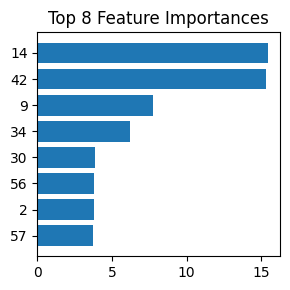

In [40]:
def Post_Proccessing(pipeline):
    model = pipeline.named_steps['reg']
    
    # Step 3: Get Feature Importances
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    # Limit to first 8 features
    top_indices = sorted_indices[:8]
    top_importances = feature_importances[top_indices]
    top_names = np.array(feature_names)[top_indices]

    printt(top_names,'top_names')
    #print_features(X,y,top_names)
    # Plot
    plt.figure(figsize=(3, 3))
    plt.title("Top 8 Feature Importances")
    plt.barh(range(len(top_importances)), top_importances, align="center")
    plt.yticks(range(len(top_importances)), top_names)
    plt.gca().invert_yaxis()  # Invert y-axis to have the feature with the highest importance on top
    plt.tight_layout()
    plt.show()

def Post_Proccessing_shap(pipeline):
    model = pipeline.named_steps['reg']

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Summarize the effects of all the features
    shap.summary_plot(shap_values, X_train, plot_type="bar")

Post_Proccessing(pipelines[0])


# ??

In [41]:
assert False

AssertionError: 

In [ ]:
if 0:
    # Config_params["model"] = model
    # Config_params["drop_categoric"] = drop_categoric
    drop_categoric = "TransformAll"
    Config_params["categortic_config_params"] = {**categortic_config_params, "drop_categoric": drop_categoric}
    pipeline = create_pipeline(Config_params)
    print(f"Pipeline created for model: {model}, drop_categoric: {drop_categoric}")
    # Add your code here to train the pipeline or to print further details
    
    
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_validation)
    
    # check errors             
    rms_log = np.sqrt(mean_squared_error(np.log(y_validation), np.log(y_pred)))        
    print(f"logRMS = {rms_log:.5f}")

# Stacking

In [ ]:
class keep_columns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_keep):        
        self.columns_to_keep = columns_to_keep
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns_to_keep]

In [ ]:
verbose=False
general_pipeline = Pipeline([
    ('drop_ID', drop_ID(verbose=Config_params['verbose'])),
    ('remove_nas_col', remove_NAs_col(threshold=Config_params['nan_counts_threshold'], verbose=verbose)),
    ('imput_nas_row', imput_NAs_row(verbose=verbose)),
    ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose))
])
y_new = y
_X = general_pipeline.fit_transform(X, y_new)
X_train, X_validation, y_train, y_validation = train_test_split(_X, y_new, test_size=0.2, random_state=42)
verbose = Config_params['verbose']
drop_categoric = "TransformAll"
Config_params["categortic_config_params"] = {**categortic_config_params, "drop_categoric": drop_categoric}
Config_params['drop_categoric'] = "TransformAll"
config_params = Config_params
model = CatBoostRegressor(random_state=42, verbose=int(Config_params['verbose']))
cat_pipeline = Pipeline([
    ('drop_ID', drop_ID(verbose=Config_params['verbose'])),
    ('remove_nas_col', remove_NAs_col(threshold=Config_params['nan_counts_threshold'], verbose=verbose)),
    ('imput_nas_row', imput_NAs_row(verbose=verbose)),
    ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose)),
    ('reg', model)  # Use the dynamically selected model
])
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_pipeline = Pipeline([
    ('drop_ID', drop_ID(verbose=Config_params['verbose'])),
    ('remove_nas_col', remove_NAs_col(threshold=config_params['nan_counts_threshold'], verbose=verbose)),
    ('imput_nas_row', imput_NAs_row(verbose=verbose)),
    ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose)),
    ('reg', model)  # Use the dynamically selected model
])
model = KNeighborsRegressor(n_neighbors=5)
kmeans_pipeline = Pipeline([
    ('drop_ID', drop_ID(verbose=Config_params['verbose'])),
    ('remove_nas_col', remove_NAs_col(threshold=config_params['nan_counts_threshold'], verbose=verbose)),
    ('imput_nas_row', imput_NAs_row(verbose=verbose)),
    ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose)),
    ('keep_columns', keep_columns(['Neighborhood'])),
    ('reg', model)  # Use the dynamically selected model
])

model = LinearRegression()
lreg_pipeline = Pipeline([
    ('drop_ID', drop_ID(verbose=Config_params['verbose'])),
    ('remove_nas_col', remove_NAs_col(threshold=config_params['nan_counts_threshold'], verbose=verbose)),
    ('imput_nas_row', imput_NAs_row(verbose=verbose)),
    ('handle_categoric', handle_categoric(categortic_config_params,verbose=verbose)),
    #('keep_columns', keep_columns(['Neighborhood'])),
    ('reg', model)  # Use the dynamically selected model
])

In [ ]:
model = CatBoostRegressor(random_state=42, verbose=int(Config_params['verbose']))
cat_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reg', model)  # Use the dynamically selected model
])
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reg', model)  # Use the dynamically selected model
])
model = KNeighborsRegressor(n_neighbors=50)
kmeans_pipeline = Pipeline([
    ('keep_columns', keep_columns(['Neighborhood'])),
    ('reg', model)  # Use the dynamically selected model
])

model = LinearRegression()
lreg_pipeline = Pipeline([
    ('reg', model)  # Use the dynamically selected model
])

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=10000000, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=10000000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42) 
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
# def blend_models_predict(X):
#     return ((0.1 * elastic_model_full_data.predict(X)) + \
#             (0.05 * lasso_model_full_data.predict(X)) + \
#             (0.1 * ridge_model_full_data.predict(X)) + \
#             (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#             (0.15 * xgb_model_full_data.predict(X)) + \
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.3 * stack_gen_model.predict(np.array(X))))
    
# print('START Fit')

# print('stack_gen')
# stack_gen_model = stack_gen.fit(X_train, y_train)

# print('elasticnet')
# elastic_model_full_data = elasticnet.fit(X_train, y_train)

# print('Lasso')
# lasso_model_full_data = lasso.fit(X_train, y_train)

# print('Ridge')
# ridge_model_full_data = ridge.fit(X_train, y_train)

# print('Svr')
# svr_model_full_data = svr.fit(X_train, y_train)

# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X_train, y_train)

# print('xgboost')
# xgb_model_full_data = xgboost.fit(X_train, y_train)

# print('lightgbm')
# lgb_model_full_data = lightgbm.fit(X_train, y_train)

# predict_func = blend_models_predict

In [ ]:
models = [
    ('cat', cat_pipeline),
    ('xgb', xgb_pipeline),
    ('gbr', gbr),
    ('lreg', lreg_pipeline),
    ('lasso', lasso),
    ('elasticnet', elasticnet),
    ('svr', svr),
    ('lightgbm', lightgbm),
    ('xgboost', xgboost),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
X_combined = pd.concat([X_train, X_validation], axis=0)
y_combined = pd.concat([y_train, y_validation], axis=0)
base_models = (cat_pipeline, xgb_pipeline, gbr,lreg_pipeline,lasso,elasticnet,svr, lightgbm,xgboost,RandomForestRegressor(n_estimators=100, random_state=42))
base_models = (cat_pipeline, gbr, lightgbm, xgboost)
meta_learner = LinearRegression()
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_learner)
# stacking_regressor = StackingCVRegressor(regressors=base_models,
#                                 meta_regressor=meta_learner,
#                                 use_features_in_secondary=True)
# stacking_regressor.fit(X_train, y_train)       
# predict_func = stacking_regressor.predict

In [ ]:
for model in models:
    rms_log = cv_rmse(model[1], X_combined, y_combined)
    print(f"model : {model[0]} mean score : {rms_log.mean()} std : {rms_log.std()}")
# rms_log = cv_rmse(cat_pipeline, X_combined, y_combined)
# print("cat boost regressor: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
# rms_log = cv_rmse(xgb_pipeline, X_combined, y_combined)
# print("xgb_pipeline regressor: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
# rms_log = cv_rmse(gbr, X_combined, y_combined)
# print("gbr regressor: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
# rms_log = cv_rmse(lreg_pipeline, X_combined, y_combined)
# print("lreg_pipeline regressor: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
# rms_log = cv_rmse(lasso, X_combined, y_combined)
# print("lasso regressor: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
# rms_log = cv_rmse(elasticnet, X_combined, y_combined)
# print("elasticnet: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
# rms_log = cv_rmse(svr, X_combined, y_combined)
# print("svr: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))
# rms_log = cv_rmse(svr, X_combined, y_combined)
# print("svr: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))

In [ ]:
rms_log = cv_rmse(stacking_regressor, X_combined, y_combined)
print("stacking regressor: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))

In [ ]:
rms_log = cv_rmse(stacking_regressor, X_combined, y_combined)
print("stacking cv regressor: {:.4f} ({:.4f})\n".format(rms_log.mean(), rms_log.std()))

In [ ]:
y_pred = predict_func(X_validation)
y_test = y_validation
rms_log = np.sqrt(mean_squared_error(y_test, y_pred)) 
print(f"logRMS = {rms_log:.5f}")

In [ ]:
cv_results = stacking_regressor.cv_results_
cv_results

# Submission
Finally predict on the competition test data using the model.

In [ ]:
# fit again now on full data_set to improve results
if 1:
    y_pred = CatKeepAllModel(X,y,testset_df)
if 0:
    y_pred = CombModel(X,y,testset_df)
    
y_pred = np.exp(y_pred)
 
output = pd.DataFrame({'Id': id_file,
                       'SalePrice': y_pred.squeeze()})
# create CSV
output.to_csv('./project/submission.csv', index=False)
output.head()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Fit the scaler to the pivot table data and transform the data
# standardized_data = pd.DataFrame(scaler.fit_transform(numeric_features_df), columns=numeric_features_df.columns, index=numeric_features_df.index)
# lof_clf = LocalOutlierFactor()
# lof_clf.fit_predict(standardized_data)
# lof_scores = lof_clf.negative_outlier_factor_
# lof_scores = pd.DataFrame({'score': lof_scores}, index=numeric_features_df.index)
# combined_df = pd.concat([lof_scores, numeric_features_df], axis=1).sort_values('score')
# combined_df.head(10)